In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

sys.path.append('/home/kian/Bureaublad/Repo')
from MTP.FVSimulation_phase_density.Finite_volume_method_1D import *

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_103dBm__TmK20_avgpulse_ampphase.csv'
length = 90

lambdanm = 402
KID402 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 673
KID673 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 986
KID986 = KID_data(chippath,lambdanm,filename,length)

lambdanm = 1545
KID1545 = KID_data(chippath,lambdanm,filename,length)

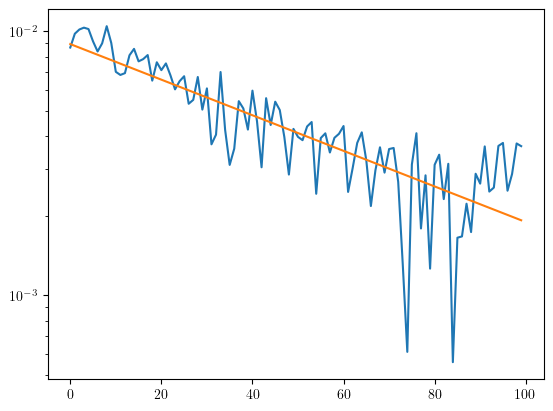

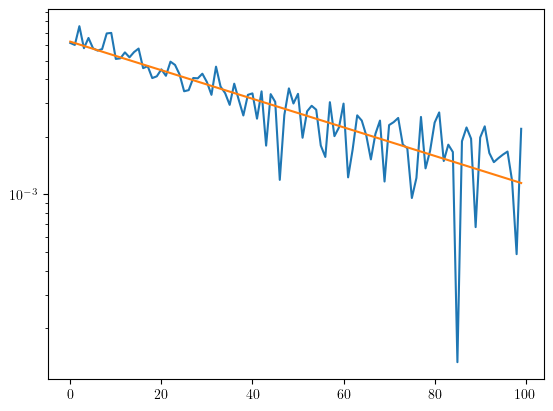

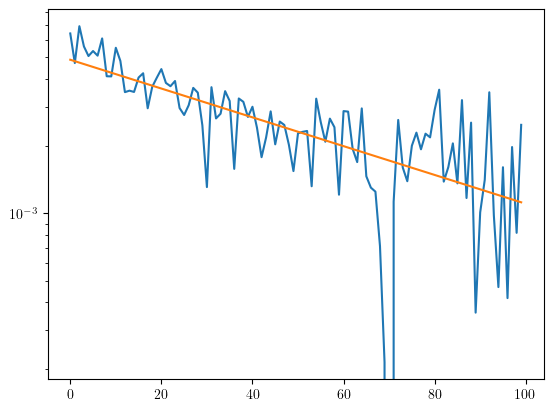

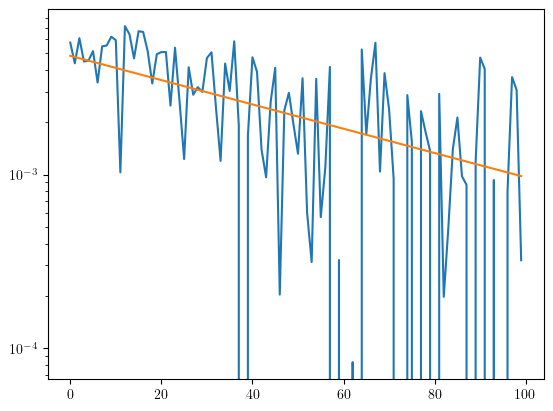

In [3]:
KID402.fit_tail(start=150,end=250)
KID673.fit_tail(start=150,end=250)
KID986.fit_tail(start=150,end=250)
KID1545.fit_tail(start=130,end=230)

In [4]:
print(KID402.tauqpstar,KID402.tauqpstarstd)
print(KID673.tauqpstar,KID673.tauqpstarstd)
print(KID986.tauqpstar,KID986.tauqpstarstd)
print(KID1545.tauqpstar,KID1545.tauqpstarstd)
print(KID402.L)
print(KID673.L)
print(KID986.L)
print(KID1545.L)

L=np.mean([KID402.L,KID673.L,KID986.L,KID1545.L])

KIDdict = {
    402 : KID402,
    673 : KID673,
    986 : KID986,
    1545 : KID1545
}

64.47248733519922 4.86899916554073
58.248553397863745 4.300854595584184
67.3438194726096 6.939516763746381
62.03713253438946 11.676947426565471
0.015510492015003163
0.017167808325977668
0.014849172616452574
0.016119378171543686


In [5]:
simtime = 80
leeway = 0

FITx = np.arange(simtime-leeway)*KID402.dt
FITy = {}
for l in [402,673,986,1545]:
    indmin = np.argmax(KIDdict[l].phase)
    indmax = indmin + simtime - leeway
    FITy[l] = KIDdict[l].phase[indmin:indmax]

plotdatay = np.array([FITy[402],FITy[673],FITy[986],FITy[1545]])
fitdatay = plotdatay.ravel()

def func_to_parallelize(t,D,K,phi_init,l,KID):
     SIM = KID_sim(KID,D,K,phi_init/l,0.01,1/2,sigma_IC=2,L=L,simtime_approx=simtime)
     return np.interp(t,SIM.t_axis,SIM.timeseriestheta)
     
def fitfunc(t,D1,D2,D3,D4,K,IC):
     datalist = Parallel(n_jobs=4)(delayed(func_to_parallelize)(t,D,K,IC,l,KIDdict[l]) for D,l in zip([D1,D2,D3,D4],[402,673,986,1545]))
     return np.concatenate(datalist)

In [6]:
popt, pcov = curve_fit(fitfunc,FITx,fitdatay,p0=[50,50,50,50,500,500],bounds=[0,np.inf])

  0%|          | 6/8000 [00:00<06:46, 19.64it/s]/home/kian/Bureaublad/Repo/MTP/FVSimulation_phase_density/Finite_volume_method_1D.py:199: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return fsolve(lambda Q_next : self.CN_eqs(dt,dx,D,L,K,Q_prev,Q_next), Q_prev)
  0%|          | 17/8000 [00:00<06:47, 19.61it/s]/home/kian/Bureaublad/Repo/MTP/FVSimulation_phase_density/Finite_volume_method_1D.py:199: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda Q_next : self.CN_eqs(dt,dx,D,L,K,Q_prev,Q_next), Q_prev)
100%|██████████| 8000/8000 [02:31<00:00, 52.96it/s]


In [7]:
# Display parameters, standard deviation, and correlation coefficient
parameters = ['D1', 'D2', 'D3', 'D4','K','IC/l']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.3f}\t+/-\t{std:.3f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.3f}")

Parameters:
D1:	0.051	+/-	0.132
D2:	0.000	+/-	0.071
D3:	0.000	+/-	0.073
D4:	0.000	+/-	0.077
K:	11.703	+/-	0.728
IC/l:	715.620	+/-	42.558

Correlation Coefficients:
D1 vs D2: 0.366
D1 vs D3: 0.319
D1 vs D4: 0.261
D1 vs K: 0.707
D1 vs IC/l: 0.523
D2 vs D3: 0.225
D2 vs D4: 0.185
D2 vs K: 0.499
D2 vs IC/l: 0.368
D3 vs D4: 0.161
D3 vs K: 0.432
D3 vs IC/l: 0.313
D4 vs K: 0.351
D4 vs IC/l: 0.246
K vs IC/l: 0.843


100%|██████████| 8000/8000 [02:35<00:00, 51.35it/s]


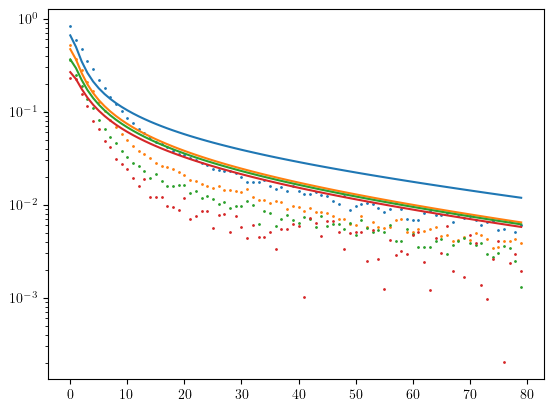

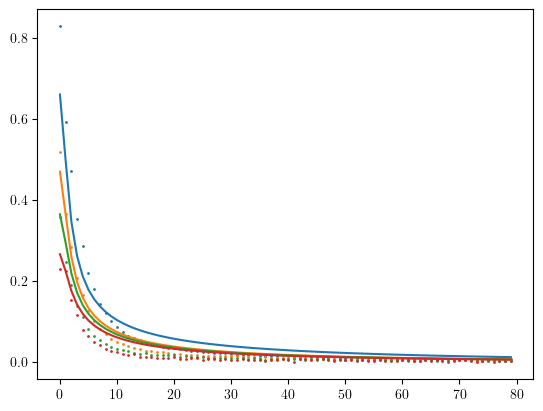

In [8]:
plotfit = fitfunc(FITx,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])
plotfit = np.reshape(plotfit,plotdatay.shape)
for y,fit in zip(plotdatay,plotfit):
    plt.scatter(FITx,y,s=1)
    plt.semilogy(FITx,fit)
plt.show()
for y,fit in zip(plotdatay,plotfit):
    plt.scatter(FITx,y,s=1)
    plt.plot(FITx,fit)
plt.show()